In [1]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data
y = data.target

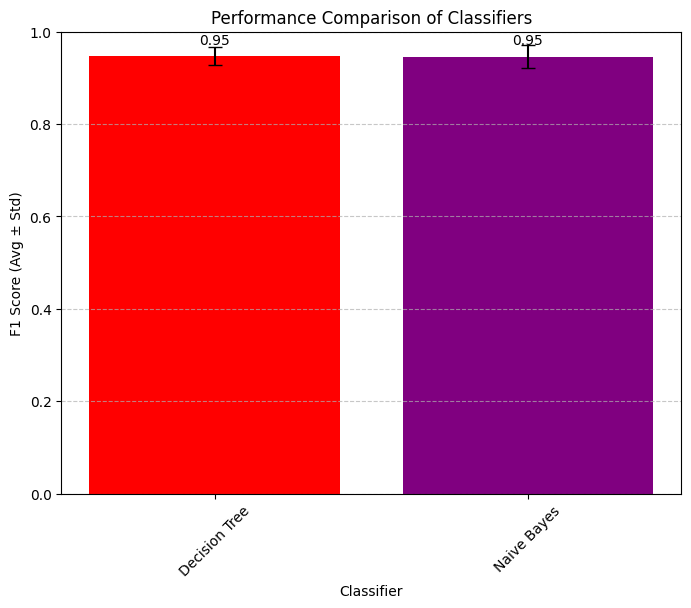

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# This class contains different methods 
class Decision_Tree_Information_Gain:

    #Constructor defined 
    def __init__(self, max_depth=None): 
        self.max_depth = max_depth
        
    #Training of decision tree model on the provided dataset that has 'X' features and 'y' labels.
    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.tree = self.growth_of_tree(X, y)
        
    #Function to grow the tree recursively.
    def growth_of_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        # This is the criteria for stopping of growth when maximum depth is achieved.
        if (self.max_depth is not None and depth == self.max_depth) or n_labels == 1:
            return Node(value=self.Most_Common_Label(y))

        # Search for best split possible
        Best_Split = self.search_best_split(X, y)
        if Best_Split is None:
            return Node(value=self.Most_Common_Label(y))
        
        # Tree growing recursively
        all_left_indices = np.where(X[:, Best_Split['feature']] <= Best_Split['threshold'])[0]
        all_right_indices = np.where(X[:, Best_Split['feature']] > Best_Split['threshold'])[0]

        Left_tree = self.growth_of_tree(X[all_left_indices], y[all_left_indices], depth + 1)
        Right_tree = self.growth_of_tree(X[all_right_indices], y[all_right_indices], depth + 1)

        return Node(feature=Best_Split['feature'], threshold=Best_Split['threshold'],
                    left=Left_tree, right=Right_tree)
        
    #Finds the best possible feature and threshold to split the data 
    def search_best_split(self, X, y):
        Best_Split = None
        Best_Info_Gain = -1

        for feature in range(self.n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                all_left_indices = np.where(X[:, feature] <= threshold)[0]
                all_right_indices = np.where(X[:, feature] > threshold)[0]

                if len(all_left_indices) > 0 and len(all_right_indices) > 0:
                    info_gain = self.Information_gained(y, y[all_left_indices], y[all_right_indices])
                    if info_gain > Best_Info_Gain:
                        Best_Split = {'feature': feature, 'threshold': threshold}
                        Best_Info_Gain = info_gain

        return Best_Split
    # Gets the information from the entropy of parent and their child nodes.
    def Information_gained(self, parent, left_child, right_child):
        p = len(parent)
        pl = len(left_child)
        pr = len(right_child)
        
        return self.Entropy(parent) - (pl/p) * self.Entropy(left_child) - (pr/p) * self.Entropy(right_child)

    #Calculates the entropy
    def Entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    #Returns the common label from a group of labels.
    def Most_Common_Label(self, y):
        labels, counts = np.unique(y, return_counts=True)
        return labels[np.argmax(counts)]
    
    #Predicts the class labels of given group of features.
    def predict(self, X):
        return np.array([self.Prediction_Tree(x, self.tree) for x in X])

    #Travels the decision tree recursively to predict the class label
    def Prediction_Tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.Prediction_Tree(x, node.left)
        else:
            return self.Prediction_Tree(x, node.right)
            
    def get_params(self, deep=True):
        return {'max_depth': self.max_depth}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#Describes the nodes of the decision tree consisting of various attributes
class Node:
    def __init__(self, feature=None, threshold=None, value=None, left=None, right=None):
        self.feature = feature
        self.threshold = threshold
        self.value = value
        self.left = left
        self.right = right

# Defined Naive Bayes Classifier with Gaussian modeling
class Naive_Bayes_Classifier_Gaussian_Modeling:

    #Training of Naive Bayes Classifier with Gaussian modeling on the provided data that has 'X' features and 'y' labels.
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = np.array([np.mean(y == c) for c in self.classes])
        self.class_means = [np.mean(X[y == c], axis=0) for c in self.classes]
        self.class_vars = [np.var(X[y == c], axis=0) for c in self.classes]

    #Calculates the probability density function of the given sample.
    def Gaussian_Density(self, x, mean, var):
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x - mean)**2 / (2 * var))

    #Calculates the class probabilites of the given samples.
    def Predicting_Class_Probas(self, x):
        class_probs = []
        for c in self.classes:
            prior = self.class_priors[c == self.classes]
            likelihood = np.prod(self.Gaussian_Density(x, self.class_means[c], self.class_vars[c]))
            class_probs.append(prior * likelihood)
        return class_probs / np.sum(class_probs)

    #For a given group of features , predicts the class labels
    def predict(self, X):
        return np.array([np.argmax(self.Predicting_Class_Probas(x)) for x in X])
        
    def get_params(self, deep=True):
        return {}

    def set_params(self, **parameters):
        return self

# Evaluation of classifiers using stratified 10-fold cross-validation 
def Evaluation_of_Classifier(clf, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X, y, cv=skf, scoring='f1')
    return f1_scores

# Instantiation of  Decision Tree Classifier and Naive Bayes Classifier
dt_classifier = Decision_Tree_Information_Gain()
nb_classifier = Naive_Bayes_Classifier_Gaussian_Modeling()

# Evaluatation of  Decision Tree Classifier
dt_f1_scores = Evaluation_of_Classifier(dt_classifier, X, y)
dt_mean_f1 = np.mean(dt_f1_scores)
dt_std_f1 = np.std(dt_f1_scores)

# Evaluatation of  Naive Bayes Classifier
nb_f1_scores = Evaluation_of_Classifier(nb_classifier, X, y)
nb_mean_f1 = np.mean(nb_f1_scores)
nb_std_f1 = np.std(nb_f1_scores) 

# Ploted performance comparison consisting of  error bars
classifiers = ['Decision Tree', 'Naive Bayes']
mean_f1_scores = [dt_mean_f1, nb_mean_f1]
std_f1_scores = [dt_std_f1, nb_std_f1]

plt.figure(figsize=(8, 6))
bars=plt.bar(classifiers, mean_f1_scores, yerr=std_f1_scores, capsize=5, color=['red', 'purple'])

#Added annotations to show the mean F1 score above both the bars.
for bar, mean_f1 in zip(bars, mean_f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{mean_f1:.2f}', ha='center', va='bottom')

plt.xlabel('Classifier')
plt.ylabel('F1 Score (Avg ± Std)')
plt.title('Performance Comparison of Classifiers')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


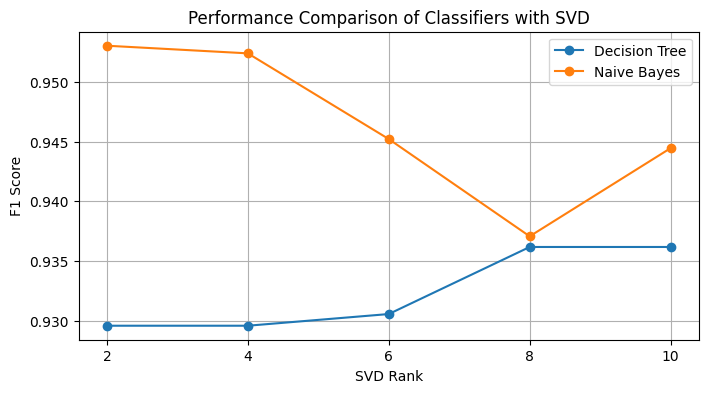

In [6]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt




# Splitting of  data into 80% train and  20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Implementing truncated svd from scratch.

def Truncated_Svd(X,k):
    X_centered = X - np.mean(X, axis=0)

    # Calculating of  the covariance matrix.
    Covariance_Matrix = np.dot(X_centered.T, X_centered)

    # Eigen decomposition is performed on the covariance matrix.
    eigenvalues, eigenvectors = np.linalg.eigh(Covariance_Matrix)

    # Selected  top k eigenvectors by sorting eigen values in descending order.
    Top_k_Indices = np.argsort(eigenvalues)[::-1][:k]
    U = eigenvectors[:,  Top_k_Indices]
    
    # To prevent errors due to negative values , taking only positive/absolute values.
    S = np.sqrt(np.abs(eigenvalues[ Top_k_Indices]))

    # Right singular vector calculation
    Vt = np.dot(U.T, X_centered.T) / S[:, np.newaxis]  # Shape of Vt will be (k, n_features)

    return U, S, Vt

#Applying SVD in order to do dimensionality reduction
def Applying_SVD(X_train, X_test, rank):
    
    # Fitting of  SVD on the training data
    U_train, _, Vt_train = Truncated_Svd(X_train, rank)

    # Projected training data into the reduced space as told.
    X_train_reduced = np.dot(X_train, U_train)

    # Projected test data into the reduced space to avoid data leaks.
    X_test_reduced = np.dot(X_test, U_train)

    return X_train_reduced, X_test_reduced

#  Decision Tree Classifier with Information Gain criterion implemented from scratch
class Decision_Tree_Information_Gain:

    #Constructor defined 
    def __init__(self, max_depth=None): 
        self.max_depth = max_depth
        
    #Training of decision tree model on the provided dataset that has 'X' features and 'y' labels.
    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.tree = self.growth_of_tree(X, y)
        
    #Function to grow the tree recursively.
    def growth_of_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        # This is the criteria for stopping of growth when maximum depth is achieved.
        if (self.max_depth is not None and depth == self.max_depth) or n_labels == 1:
            return Node(value=self.Most_Common_Label(y))

        # Search for best split possible
        Best_Split = self.search_best_split(X, y)
        if Best_Split is None:
            return Node(value=self.Most_Common_Label(y))
        
        # Tree growing recursively
        all_left_indices = np.where(X[:, Best_Split['feature']] <= Best_Split['threshold'])[0]
        all_right_indices = np.where(X[:, Best_Split['feature']] > Best_Split['threshold'])[0]

        Left_tree = self.growth_of_tree(X[all_left_indices], y[all_left_indices], depth + 1)
        Right_tree = self.growth_of_tree(X[all_right_indices], y[all_right_indices], depth + 1)

        return Node(feature=Best_Split['feature'], threshold=Best_Split['threshold'],
                    left=Left_tree, right=Right_tree)
        
    #Finds the best possible feature and threshold to split the data 
    def search_best_split(self, X, y):
        Best_Split = None
        Best_Info_Gain = -1

        for feature in range(self.n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                all_left_indices = np.where(X[:, feature] <= threshold)[0]
                all_right_indices = np.where(X[:, feature] > threshold)[0]

                if len(all_left_indices) > 0 and len(all_right_indices) > 0:
                    info_gain = self.Information_gained(y, y[all_left_indices], y[all_right_indices])
                    if info_gain > Best_Info_Gain:
                        Best_Split = {'feature': feature, 'threshold': threshold}
                        Best_Info_Gain = info_gain

        return Best_Split
    # Gets the information from the entropy of parent and their child nodes.
    def Information_gained(self, parent, left_child, right_child):
        p = len(parent)
        pl = len(left_child)
        pr = len(right_child)
        
        return self.Entropy(parent) - (pl/p) * self.Entropy(left_child) - (pr/p) * self.Entropy(right_child)

    #Calculates the entropy
    def Entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    #Returns the common label from a group of labels.
    def Most_Common_Label(self, y):
        labels, counts = np.unique(y, return_counts=True)
        return labels[np.argmax(counts)]
    
    #Predicts the class labels of given group of features.
    def predict(self, X):
        return np.array([self.Prediction_Tree(x, self.tree) for x in X])

    #Travels the decision tree recursively to predict the class label
    def Prediction_Tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.Prediction_Tree(x, node.left)
        else:
            return self.Prediction_Tree(x, node.right)
            
    def get_params(self, deep=True):
        return {'max_depth': self.max_depth}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#Described nodes of decision tree of consisting various attributes
class Node:
    def __init__(self, feature=None, threshold=None, value=None, left=None, right=None):
        self.feature = feature
        self.threshold = threshold
        self.value = value
        self.left = left
        self.right = right

# Defined Naive Bayes Classifier with Gaussian modeling
class Naive_Bayes_Classifier_Gaussian_Modeling:

    #Training of Naive Bayes Classifier with Gaussian modeling on the provided data that has 'X' features and 'y' labels.
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = np.array([np.mean(y == c) for c in self.classes])
        self.class_means = [np.mean(X[y == c], axis=0) for c in self.classes]
        self.class_vars = [np.var(X[y == c], axis=0) for c in self.classes]

    #Calculates the probability density function of the given sample.
    def Gaussian_Density(self, x, mean, var):
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x - mean)**2 / (2 * var))

    #Calculates the class probabilites of the given samples.
    def Predicting_Class_Probas(self, x):
        class_probs = []
        for c in self.classes:
            prior = self.class_priors[c == self.classes]
            likelihood = np.prod(self.Gaussian_Density(x, self.class_means[c], self.class_vars[c]))
            class_probs.append(prior * likelihood)
        return class_probs / np.sum(class_probs)

    #For a given group of features , predicts the class labels
    def predict(self, X):
        return np.array([np.argmax(self.Predicting_Class_Probas(x)) for x in X])
        
    def get_params(self, deep=True):
        return {}

    def set_params(self, **parameters):
        return self


# Listing  of SVD ranks for evaluation in the line graph.
svd_ranks = [2, 4, 6, 8, 10]

# Dictionary to store the performance of both the classifiers.
classifier_results = {'Decision Tree': [], 'Naive Bayes': []}

# Evaluation of both the classifiers for each SVD rank.
for rank in svd_ranks:
    X_train_reduced, X_test_reduced = Applying_SVD(X_train, X_test, rank)
    
    dt_classifier = Decision_Tree_Information_Gain()
    nb_classifier = Naive_Bayes_Classifier_Gaussian_Modeling()
    
    # Fitting of decision Tree Classifier
    dt_classifier.fit(X_train_reduced, y_train)
    dt_predictions = dt_classifier.predict(X_test_reduced)
    dt_mean_f1 = f1_score(y_test, dt_predictions)
    
    # Fitting of  Naive Bayes Classifier
    nb_classifier.fit(X_train_reduced, y_train)
    nb_predictions = nb_classifier.predict(X_test_reduced)
    nb_mean_f1 = f1_score(y_test, nb_predictions)
    
    # Storing of results 
    classifier_results['Decision Tree'].append(dt_mean_f1)
    classifier_results['Naive Bayes'].append(nb_mean_f1)

# Plotting the comparison of performance of both classifiers in the line graph.
plt.figure(figsize=(8, 4))
for classifier, results in classifier_results.items():
    plt.plot(svd_ranks, results, label=classifier, marker='o')

plt.xlabel('SVD Rank')
plt.ylabel('F1 Score')
plt.title('Performance Comparison of Classifiers with SVD')
plt.xticks(svd_ranks)
plt.legend()
plt.grid(True)
plt.show()


In [14]:
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X, y, test_size=0.3, random_state=42)

# Define classifiers
dt_classifier = Decision_Tree_Information_Gain()
nb_classifier = Naive_Bayes_Classifier_Gaussian_Modeling()

# Define the feature selection sample (20% stratified random sample)
X_feature_selection, _, y_feature_selection, _ = train_test_split(
    X_train_real, y_train_real, test_size=0.2, stratify=y_train_real, random_state=42
)

# Randomization and feature importance evaluation

def evaluate_feature_importance(X, y, model, random_state=42):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    importance_scores = []

    for feature_idx in range(X.shape[1]):
        X_randomized = X.copy()
        np.random.seed(random_state)
        np.random.shuffle(X_randomized[:, feature_idx])

        scores = cross_val_score(model, X_randomized, y, cv=skf, scoring='f1')
        importance_scores.append(np.mean(scores))

    return importance_scores

# Evaluate feature importance with randomization for Decision Tree
dt_feature_importance = evaluate_feature_importance(X_feature_selection, y_feature_selection, dt_classifier)

# Evaluate feature importance with randomization for Naive Bayes
nb_feature_importance = evaluate_feature_importance(X_feature_selection, y_feature_selection, nb_classifier)

# Get the top 10 most important features for both classifiers
top_features_dt = np.argsort(dt_feature_importance)[::-1][:10]
top_features_nb = np.argsort(nb_feature_importance)[::-1][:10]

# Calculate percentage drop in F1 score for each feature (compared to original)
dt_original_scores = cross_val_score(dt_classifier, X_feature_selection[:, top_features_dt], y_feature_selection, cv=5, scoring='f1')
nb_original_scores = cross_val_score(nb_classifier, X_feature_selection[:, top_features_nb], y_feature_selection, cv=5, scoring='f1')

percentage_drop_dt = [(dt_original_scores.mean() - score) / dt_original_scores.mean() * 100 for score in dt_feature_importance[top_features_dt]]
percentage_drop_nb = [(nb_original_scores.mean() - score) / nb_original_scores.mean() * 100 for score in nb_feature_importance[top_features_nb]]

# Plot feature importance comparison (percentage drop in F1 score)
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(top_features_dt))

plt.bar(index, percentage_drop_dt, width=bar_width, label='Decision Tree')
plt.bar(index + bar_width, percentage_drop_nb, width=bar_width, label='Naive Bayes')

plt.xlabel('Feature Index (Top 10 Features)')
plt.ylabel('Percentage Drop in F1 Score (%)')
plt.title('Percentage Drop in F1 Score due to Feature Randomization (Top 10 Features)')
plt.xticks(index + bar_width / 2, top_features_dt)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate performance with top features using both classifiers
def evaluate_top_features_performance(X_train, y_train, X_test, y_test, model, top_features):
    scores = []

    for n in range(1, len(top_features) + 1):
        selected_features = top_features[:n]
        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]

        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        f1 = f1_score(y_test, y_pred)
        scores.append(f1)

    return scores

# Evaluate performance with top features for Decision Tree
dt_performance = evaluate_top_features_performance(X_train_real, y_train_real, X_test_real, y_test_real, dt_classifier, top_features_dt)

# Evaluate performance with top features for Naive Bayes
nb_performance = evaluate_top_features_performance(X_train_real, y_train_real, X_test_real, y_test_real, nb_classifier, top_features_nb)

# Plot performance comparison with top features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(top_features_dt) + 1), dt_performance, label='Decision Tree')
plt.plot(range(1, len(top_features_nb) + 1), nb_performance, label='Naive Bayes')
plt.xlabel('Number of Top Features')
plt.ylabel('F1 Score')
plt.title('Performance of Classifiers with Top 10 Features')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index